In [1]:
!pip install mxnet=="1.4.1"

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import gluonts
gluonts.__version__

'0.4.2'

In [4]:
import mxnet
mxnet.__version__

'1.4.1'

In [5]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


INFO:root:Using CPU


In [6]:
dataname = "m4_hourly"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_hourly.


In [7]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_end2003q3', 'm4_quarterly_end2013q1', 'm4_quarterly_end2015q1', 'm4_quarterly_finance', 'm4_quarterly_id

In [8]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

# check length of the series
print("length train dataset", len(dataset.train))
print("length test dataset", len(dataset.train))


dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train dataset 414
length test dataset 414


In [9]:
train_entry

{'start': Timestamp('1750-01-01 00:00:00', freq='H'),
 'target': array([605., 586., 586., 559., 511., 443., 422., 395., 382., 370., 383.,
        397., 420., 455., 493., 554., 610., 666., 715., 755., 778., 794.,
        806., 808., 776., 723., 709., 660., 585., 527., 462., 437., 413.,
        407., 404., 420., 441., 471., 526., 571., 612., 635., 613., 608.,
        614., 637., 669., 683., 687., 660., 661., 632., 573., 521., 481.,
        452., 447., 425., 427., 441., 438., 472., 528., 596., 661., 708.,
        754., 781., 808., 819., 820., 801., 770., 717., 697., 655., 607.,
        552., 512., 475., 452., 436., 429., 433., 430., 472., 536., 611.,
        662., 705., 707., 718., 733., 741., 737., 710., 647., 593., 564.,
        528., 507., 466., 428., 396., 382., 371., 374., 372., 373., 406.,
        451., 480., 487., 487., 494., 505., 519., 535., 560., 570., 551.,
        541., 552., 521., 477., 426., 395., 370., 357., 349., 362., 374.,
        402., 427., 456., 500., 558., 608., 661.

## Plot Series

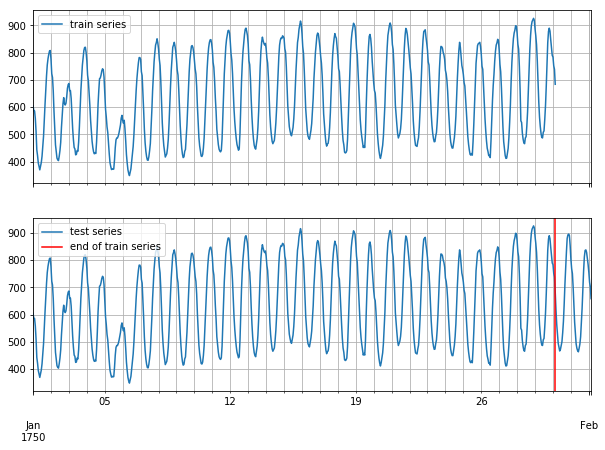

In [10]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [11]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [12]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df

## Results

In [ ]:
results = pd.DataFrame()

for i in range(45, 47):
    print("Seed:", i)
    df = deepar(data="m4_yearly_demographic", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

In [14]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_yearly_finance", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_finance.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 355673
100%|██████████| 200/200 [00:10<00:00, 19.09it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[0] Elapsed time 10.485 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.864753
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:08<00:00, 24.16it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[1] Elapsed time 8.283 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.184362
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:09<00:00, 20.70it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[2] Elapsed time 9.676 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.979116
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:08<00:00, 22.37it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[3] Elapsed time 8.946 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.787494
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 25.99it/s, avg_epoch_los

100%|██████████| 200/200 [00:05<00:00, 39.89it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[37] Elapsed time 5.017 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.326939
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 37.10it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[38] Elapsed time 5.392 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.275466
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 37.83it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[39] Elapsed time 5.290 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.250831
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 39.25it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[40] Elapsed time 5.101 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.263610
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 41.74it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[41] Elapsed time 4.796 second

100%|██████████| 200/200 [00:04<00:00, 46.18it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[74] Elapsed time 4.335 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.116797
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.12it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[75] Elapsed time 4.440 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.083930
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.68it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[76] Elapsed time 4.380 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.102846
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.29it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[77] Elapsed time 4.421 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.091813
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 44.82it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[78] Elapsed time 4.465 seconds


100%|██████████| 200/200 [00:04<00:00, 45.12it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[111] Elapsed time 4.434 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.957077
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.38it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[112] Elapsed time 4.412 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.934535
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.04it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[113] Elapsed time 4.443 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.916396
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.31it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[114] Elapsed time 4.229 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.939569
INFO:root:Epoch[115] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.80it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[115] Elapsed time

100%|██████████| 200/200 [00:05<00:00, 35.42it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[147] Elapsed time 5.654 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.825923
INFO:root:Epoch[148] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 37.52it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[148] Elapsed time 5.342 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.790515
INFO:root:Epoch[149] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 36.13it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[149] Elapsed time 5.539 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.823910
INFO:root:Epoch[150] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 35.65it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[150] Elapsed time 5.612 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.787666
INFO:root:Epoch[151] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 38.92it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[151] Elapsed 

100%|██████████| 200/200 [00:04<00:00, 42.15it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[183] Elapsed time 4.750 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.737227
INFO:root:Epoch[184] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 40.12it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[184] Elapsed time 4.989 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.689443
INFO:root:Epoch[185] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 42.69it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[185] Elapsed time 4.692 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.700131
INFO:root:Epoch[186] Learning rate is 0.00025
100%|██████████| 200/200 [00:05<00:00, 36.89it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[186] Elapsed time 5.430 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.706044
INFO:root:Epoch[187] Learning rate is 0.00025
100%|██████████| 200/200 [00:05<00:00, 36.74it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[187] Elaps

INFO:root:Epoch[219] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 45.34it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[219] Elapsed time 4.416 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.729113
INFO:root:Epoch[220] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 42.29it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[220] Elapsed time 4.733 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.718717
INFO:root:Epoch[221] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 45.47it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[221] Elapsed time 4.404 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.676687
INFO:root:Epoch[222] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 47.97it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[222] Elapsed time 4.178 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.686277
INFO:root:Loading parameters from best epoch (212)
INFO:root:Epoch[223] Learning rate is 5e-

100%|██████████| 200/200 [00:04<00:00, 44.70it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[255] Elapsed time 4.478 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=5.635514
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.32it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[256] Elapsed time 4.520 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.628939
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.01it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[257] Elapsed time 4.445 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.647145
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 44.51it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[258] Elapsed time 4.495 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.685863
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 43.83it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[259] Elapsed time

INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.16it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[292] Elapsed time 5.536 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=5.682669
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.91it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[293] Elapsed time 5.736 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.608976
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.67it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[294] Elapsed time 5.319 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.624026
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.41it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[295] Elapsed time 5.211 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.600934
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.71it/s, avg_epoch_l

INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=5.634987
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.50it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[329] Elapsed time 5.339 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.638195
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.40it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[330] Elapsed time 5.213 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.620438
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.22it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[331] Elapsed time 5.239 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.683667
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 35.85it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[332] Elapsed time 5.585 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.624014
INFO:root:Epoch[333] Learning rate is 5e-05

100%|██████████| 200/200 [00:04<00:00, 44.19it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[365] Elapsed time 4.528 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=5.620512
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.73it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[366] Elapsed time 4.377 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.606643
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.22it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[367] Elapsed time 4.329 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.611481
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.49it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[368] Elapsed time 4.398 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.582391
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.16it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[369] Elapsed time

  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 355673


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.432116  0.153929  57.153079            0.149031            0.090955   

   seed  epochs  num_batches  
0    42     400          200  
Seed: 43


100%|██████████| 200/200 [00:04<00:00, 40.37it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[0] Elapsed time 4.958 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.859551
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 38.75it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[1] Elapsed time 5.165 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.193859
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 39.31it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[2] Elapsed time 5.092 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.920085
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 37.91it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[3] Elapsed time 5.282 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.807317
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 37.14it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[4] Elapsed time 5.387 seconds
INFO:root:E

100%|██████████| 200/200 [00:04<00:00, 45.71it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[37] Elapsed time 4.377 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.269470
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.99it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[38] Elapsed time 4.351 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.281885
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 43.83it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[39] Elapsed time 4.567 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.240305
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.12it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[40] Elapsed time 4.434 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.267153
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.13it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[41] Elapsed time 4.442 second

100%|██████████| 200/200 [00:05<00:00, 39.71it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[74] Elapsed time 5.041 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.130781
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 39.48it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[75] Elapsed time 5.070 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.136288
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 38.85it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[76] Elapsed time 5.152 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.148413
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.27it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[77] Elapsed time 4.972 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.120083
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.34it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[78] Elapsed time 4.963 second

100%|██████████| 200/200 [00:05<00:00, 38.82it/s, avg_epoch_loss=6]
INFO:root:Epoch[111] Elapsed time 5.156 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.999461
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.72it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[112] Elapsed time 4.918 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.979833
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 38.29it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[113] Elapsed time 5.229 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.979735
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 39.02it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[114] Elapsed time 5.129 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.937335
INFO:root:Epoch[115] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.47it/s, avg_epoch_loss=6]
INFO:root:Epoch[115] Elapsed time 4.945

INFO:root:Epoch[148] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.87it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[148] Elapsed time 4.898 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.863080
INFO:root:Epoch[149] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 42.53it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[149] Elapsed time 4.708 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.852725
INFO:root:Epoch[150] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 43.05it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[150] Elapsed time 4.649 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.867512
INFO:root:Epoch[151] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 37.81it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[151] Elapsed time 5.291 seconds
INFO:root:Epoch[151] Evaluation metric 'epoch_loss'=5.868589
INFO:root:Epoch[152] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 42.02it/s, avg_epoch_

INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.815041
INFO:root:Epoch[185] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 40.27it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[185] Elapsed time 4.972 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.774105
INFO:root:Epoch[186] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 42.24it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[186] Elapsed time 4.738 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.824203
INFO:root:Epoch[187] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 44.74it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[187] Elapsed time 4.473 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=5.743417
INFO:root:Epoch[188] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 42.53it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[188] Elapsed time 4.708 seconds
INFO:root:Epoch[188] Evaluation metric 'epoch_loss'=5.744547
INFO:root:Epoch[189] Learning rate is 0.001

INFO:root:Epoch[221] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 40.06it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[221] Elapsed time 5.001 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.614941
INFO:root:Epoch[222] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 42.57it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[222] Elapsed time 4.708 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.669094
INFO:root:Epoch[223] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 38.30it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[223] Elapsed time 5.225 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=5.655888
INFO:root:Epoch[224] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 40.39it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[224] Elapsed time 4.954 seconds
INFO:root:Epoch[224] Evaluation metric 'epoch_loss'=5.658751
INFO:root:Epoch[225] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 36.70it/s, avg_e

100%|██████████| 200/200 [00:05<00:00, 38.88it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[257] Elapsed time 5.149 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.581969
INFO:root:Epoch[258] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 40.33it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[258] Elapsed time 4.967 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.619509
INFO:root:Epoch[259] Learning rate is 0.00025
100%|██████████| 200/200 [00:05<00:00, 38.07it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[259] Elapsed time 5.256 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.551750
INFO:root:Epoch[260] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 42.45it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[260] Elapsed time 4.717 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=5.547529
INFO:root:Epoch[261] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 41.15it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[261] Elap

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=5.575171
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.76it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[293] Elapsed time 4.680 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.508519
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.75it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[294] Elapsed time 4.684 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.514590
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.97it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[295] Elapsed time 5.137 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.509673
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.41it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[296] Elapsed time 5.079 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=5.522781
INFO:root:Epoch[297] Learning rate is 5e-05

100%|██████████| 200/200 [00:04<00:00, 40.05it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[329] Elapsed time 4.996 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.474421
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.90it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[330] Elapsed time 5.015 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.486737
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.85it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[331] Elapsed time 5.290 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.452087
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.01it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[332] Elapsed time 5.273 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.499929
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.48it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[333] Elapsed time 

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.92it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[366] Elapsed time 5.147 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.469645
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.32it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[367] Elapsed time 5.224 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.480375
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.22it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[368] Elapsed time 5.847 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.448420
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.80it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[369] Elapsed time 4.788 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.503266
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.45it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.508304  0.160062  61.868333            0.155694            0.095236   

   seed  epochs  num_batches  
0    43     400          200  
Seed: 44


100%|██████████| 200/200 [00:05<00:00, 38.94it/s, avg_epoch_loss=7.71]
INFO:root:Epoch[0] Elapsed time 5.148 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.706080
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 36.52it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[1] Elapsed time 5.479 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.134948
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 35.17it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[2] Elapsed time 5.693 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.938813
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 34.86it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[3] Elapsed time 5.742 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.813265
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 36.07it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[4] Elapsed time 5.546 seconds
INFO:root:Ep

100%|██████████| 200/200 [00:04<00:00, 44.73it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[37] Elapsed time 4.475 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.291286
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.19it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[38] Elapsed time 4.430 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.284716
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 44.54it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[39] Elapsed time 4.493 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.317470
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 44.83it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[40] Elapsed time 4.470 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.265408
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 44.27it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[41] Elapsed time 4.520 seconds

100%|██████████| 200/200 [00:05<00:00, 35.97it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[74] Elapsed time 5.570 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.106058
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 37.86it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[75] Elapsed time 5.291 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.093663
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 38.38it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[76] Elapsed time 5.218 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.103254
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 36.60it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[77] Elapsed time 5.470 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.085272
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 36.63it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[78] Elapsed time 5.466 seconds


100%|██████████| 200/200 [00:08<00:00, 22.36it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[111] Elapsed time 8.954 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.032820
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 200/200 [00:09<00:00, 21.18it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[112] Elapsed time 9.448 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.991592
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 200/200 [00:08<00:00, 23.19it/s, avg_epoch_loss=6]
INFO:root:Epoch[113] Elapsed time 8.628 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.997326
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 35.89it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[114] Elapsed time 5.578 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.954874
INFO:root:Epoch[115] Learning rate is 0.001
100%|██████████| 200/200 [00:08<00:00, 22.84it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[115] Elapsed time 8.

INFO:root:Epoch[148] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 28.71it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[148] Elapsed time 6.972 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.901881
INFO:root:Epoch[149] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 27.53it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[149] Elapsed time 7.271 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.893211
INFO:root:Epoch[150] Learning rate is 0.001
100%|██████████| 200/200 [00:08<00:00, 24.00it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[150] Elapsed time 8.337 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.895049
INFO:root:Epoch[151] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 26.33it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[151] Elapsed time 7.607 seconds
INFO:root:Epoch[151] Evaluation metric 'epoch_loss'=5.871497
INFO:root:Epoch[152] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 31.63it/s, avg_epoch_lo

100%|██████████| 200/200 [00:07<00:00, 25.81it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[184] Elapsed time 7.763 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.731581
INFO:root:Epoch[185] Learning rate is 0.0005
100%|██████████| 200/200 [00:07<00:00, 26.57it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[185] Elapsed time 7.532 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.748700
INFO:root:Epoch[186] Learning rate is 0.0005
100%|██████████| 200/200 [00:07<00:00, 28.06it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[186] Elapsed time 7.145 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.751485
INFO:root:Epoch[187] Learning rate is 0.0005
100%|██████████| 200/200 [00:07<00:00, 26.83it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[187] Elapsed time 7.459 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=5.749406
INFO:root:Epoch[188] Learning rate is 0.0005
100%|██████████| 200/200 [00:07<00:00, 27.71it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[188] Elapsed 

INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.668023
INFO:root:Epoch[221] Learning rate is 0.0005
100%|██████████| 200/200 [00:07<00:00, 27.98it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[221] Elapsed time 7.155 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.674642
INFO:root:Epoch[222] Learning rate is 0.0005
100%|██████████| 200/200 [00:06<00:00, 29.10it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[222] Elapsed time 6.878 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.634068
INFO:root:Epoch[223] Learning rate is 0.0005
100%|██████████| 200/200 [00:07<00:00, 26.80it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[223] Elapsed time 7.471 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=5.707833
INFO:root:Epoch[224] Learning rate is 0.0005
100%|██████████| 200/200 [00:07<00:00, 27.06it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[224] Elapsed time 7.397 seconds
INFO:root:Epoch[224] Evaluation metric 'epoch_loss'=5.683948
INFO:root:Epoch[225] Learning rate is 0

INFO:root:Epoch[257] Learning rate is 0.00025
100%|██████████| 200/200 [00:07<00:00, 25.67it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[257] Elapsed time 7.798 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.581895
INFO:root:Epoch[258] Learning rate is 0.00025
100%|██████████| 200/200 [00:08<00:00, 24.28it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[258] Elapsed time 8.242 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.587072
INFO:root:Epoch[259] Learning rate is 0.00025
100%|██████████| 200/200 [00:09<00:00, 21.36it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[259] Elapsed time 9.367 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.600571
INFO:root:Epoch[260] Learning rate is 0.00025
100%|██████████| 200/200 [00:08<00:00, 23.50it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[260] Elapsed time 8.518 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=5.606332
INFO:root:Epoch[261] Learning rate is 0.00025
100%|██████████| 200/200 [00:08<00:00, 22.58it/s, a

INFO:root:Epoch[293] Learning rate is 0.000125
100%|██████████| 200/200 [00:07<00:00, 26.93it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[293] Elapsed time 7.434 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.510729
INFO:root:Epoch[294] Learning rate is 0.000125
100%|██████████| 200/200 [00:09<00:00, 21.88it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[294] Elapsed time 9.148 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.478027
INFO:root:Epoch[295] Learning rate is 0.000125
100%|██████████| 200/200 [00:09<00:00, 21.02it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[295] Elapsed time 9.536 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.523706
INFO:root:Epoch[296] Learning rate is 0.000125
100%|██████████| 200/200 [00:08<00:00, 23.04it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[296] Elapsed time 8.686 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=5.513903
INFO:root:Epoch[297] Learning rate is 0.000125
100%|██████████| 200/200 [00:08<00:00, 22.36i

INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 30.60it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[329] Elapsed time 6.541 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.498094
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 29.27it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[330] Elapsed time 6.839 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.495829
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.73it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[331] Elapsed time 8.091 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.450124
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.88it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[332] Elapsed time 7.732 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.442495
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 28.23it/s, avg_epoch_lo

INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=5.479529
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.74it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[366] Elapsed time 7.780 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.492571
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.07it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[367] Elapsed time 8.676 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.500558
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 26.52it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[368] Elapsed time 7.548 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.459269
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:09<00:00, 21.88it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[369] Elapsed time 9.149 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.477480
INFO:root:Epoch[370] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.397515  0.153831  55.278438            0.149597             0.09348   

   seed  epochs  num_batches  
0    44     400          200  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,3.432116,0.153929,57.153079,0.149031,0.090955,42,400,200
0,3.508304,0.160062,61.868333,0.155694,0.095236,43,400,200
0,3.397515,0.153831,55.278438,0.149597,0.093480,44,400,200


In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_yearly_industry", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_industry.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 215523


Seed: 42


100%|██████████| 200/200 [00:06<00:00, 29.89it/s, avg_epoch_loss=7.99]
INFO:root:Epoch[0] Elapsed time 6.698 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.988857
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 30.80it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[1] Elapsed time 6.499 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.393778
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 32.97it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[2] Elapsed time 6.068 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.203777
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 29.70it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[3] Elapsed time 6.739 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.102600
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 31.10it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[4] Elapsed time 6.438 seconds
INFO:root:Epo

100%|██████████| 200/200 [00:06<00:00, 32.29it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[37] Elapsed time 6.197 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.631499
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 200/200 [00:06<00:00, 29.17it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[38] Elapsed time 6.865 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.654693
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 200/200 [00:06<00:00, 29.34it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[39] Elapsed time 6.818 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.516652
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 200/200 [00:06<00:00, 31.48it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[40] Elapsed time 6.377 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.579332
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 200/200 [00:06<00:00, 31.10it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[41] Elapsed time 6.444 se

INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 200/200 [00:09<00:00, 21.84it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[74] Elapsed time 9.162 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.501914
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 200/200 [00:08<00:00, 23.60it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[75] Elapsed time 8.482 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.520338
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 200/200 [00:07<00:00, 27.55it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[76] Elapsed time 7.265 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.383064
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 200/200 [00:09<00:00, 22.21it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[77] Elapsed time 9.013 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.456989
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 200/200 [00:09<00:00, 21.52it/s, avg_epoch_loss

100%|██████████| 200/200 [00:06<00:00, 29.35it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[110] Elapsed time 6.818 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.460003
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:08<00:00, 24.84it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[111] Elapsed time 8.061 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.483333
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:08<00:00, 24.14it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[112] Elapsed time 8.294 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.383864
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:07<00:00, 27.24it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[113] Elapsed time 7.348 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.415822
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:08<00:00, 24.10it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[114] E

100%|██████████| 200/200 [00:07<00:00, 25.15it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[146] Elapsed time 7.955 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.353657
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 27.99it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[147] Elapsed time 7.152 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.427528
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:09<00:00, 21.02it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[148] Elapsed time 9.517 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.496793
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 26.72it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[149] Elapsed time 7.491 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.307785
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.20it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[150] Elapsed time 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:09<00:00, 21.52it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[183] Elapsed time 9.294 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.452302
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.36it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[184] Elapsed time 8.217 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.376018
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.43it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[185] Elapsed time 7.869 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.355387
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:10<00:00, 18.74it/s, avg_epoch_loss=6.4] 
INFO:root:Epoch[186] Elapsed time 10.676 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.402519
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 22.81it/s, avg_epoch

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.425505
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:09<00:00, 21.38it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[220] Elapsed time 9.358 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.427908
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 22.50it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[221] Elapsed time 8.902 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.282950
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.36it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[222] Elapsed time 8.571 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.409641
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.09it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[223] Elapsed time 8.667 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.479576
INFO:root:Epoch[224] Learning rate is 5e-05

100%|██████████| 200/200 [00:09<00:00, 21.88it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[256] Elapsed time 9.143 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.428043
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:09<00:00, 21.80it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[257] Elapsed time 9.180 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.258449
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.61it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[258] Elapsed time 8.141 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.412399
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.07it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[259] Elapsed time 8.672 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.449872
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.38it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[260] Elapsed time

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:09<00:00, 21.88it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[293] Elapsed time 9.142 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.237882
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 27.10it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[294] Elapsed time 7.387 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.373792
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 26.10it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[295] Elapsed time 7.669 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.406076
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 27.51it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[296] Elapsed time 7.283 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.395328
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.68it/s, avg_epoch_l

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.330597
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.45it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[330] Elapsed time 8.554 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.382463
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.07it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[331] Elapsed time 8.315 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.397928
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.13it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[332] Elapsed time 8.296 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.244752
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.74it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[333] Elapsed time 8.433 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.375980
INFO:root:Epoch[334] Learning rate is 5e-05


100%|██████████| 200/200 [00:08<00:00, 22.45it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[366] Elapsed time 8.913 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.365409
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:09<00:00, 21.30it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[367] Elapsed time 9.398 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.267584
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 27.62it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[368] Elapsed time 7.248 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.243675
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.67it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[369] Elapsed time 8.113 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.360713
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.67it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[370] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.385216  0.183626  57.690094            0.174122            0.114891   

   seed  epochs  num_batches  
0    42     400          200  
Seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 215523
100%|██████████| 200/200 [00:08<00:00, 24.97it/s, avg_epoch_loss=7.91]
INFO:root:Epoch[0] Elapsed time 8.014 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.913443
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:09<00:00, 21.47it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[1] Elapsed time 9.324 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.368820
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:08<00:00, 23.19it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[2] Elapsed time 8.634 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.188601
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 26.74it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[3] Elapsed time 7.486 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.053796
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 26.63it/s, avg_epoch_loss

100%|██████████| 200/200 [00:07<00:00, 26.50it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[37] Elapsed time 7.554 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.592569
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 26.23it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[38] Elapsed time 7.629 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.614322
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:07<00:00, 26.91it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[39] Elapsed time 7.442 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.415498
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:09<00:00, 21.21it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[40] Elapsed time 9.434 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.522249
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 200/200 [00:09<00:00, 21.74it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[41] Elapsed time 9.205 second

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.426530
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 200/200 [00:06<00:00, 32.57it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[74] Elapsed time 6.147 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.477303
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 200/200 [00:06<00:00, 29.24it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[75] Elapsed time 6.847 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.320659
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 200/200 [00:06<00:00, 30.07it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[76] Elapsed time 6.652 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.412418
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 200/200 [00:06<00:00, 30.70it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[77] Elapsed time 6.516 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.465279
INFO:root:Epoch[78] Learning rate is 0.00025
100

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.421496
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.15it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[110] Elapsed time 7.958 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.468620
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.30it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[111] Elapsed time 7.910 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.348639
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 29.53it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[112] Elapsed time 6.781 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.372208
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.83it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[113] Elapsed time 7.748 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.412810
INFO:root:Epoch[114] Learning rate is 5e-05

100%|██████████| 200/200 [00:06<00:00, 32.38it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[146] Elapsed time 6.182 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.370347
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.61it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[147] Elapsed time 6.144 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.300154
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.55it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[148] Elapsed time 6.156 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.390934
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 30.78it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[149] Elapsed time 6.499 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.483460
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.34it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[150] Elapsed time 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.97it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[183] Elapsed time 6.073 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.276605
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.96it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[184] Elapsed time 5.435 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.327764
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.47it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[185] Elapsed time 5.201 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.420933
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 35.89it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[186] Elapsed time 5.592 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.298686
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 27.28it/s, avg_epoch_l

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.263567
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 28.76it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[220] Elapsed time 6.961 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.345857
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 26.32it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[221] Elapsed time 7.610 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.390279
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.27it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[222] Elapsed time 8.596 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.309774
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.10it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[223] Elapsed time 7.976 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.270130
INFO:root:Epoch[224] Learning rate is 5e-05

100%|██████████| 200/200 [00:08<00:00, 22.77it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[256] Elapsed time 8.788 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.339546
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.58it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[257] Elapsed time 8.148 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.376376
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 26.54it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[258] Elapsed time 7.542 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.288838
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.58it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[259] Elapsed time 8.487 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.289357
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:09<00:00, 20.66it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[260] Elapsed time

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.49it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[293] Elapsed time 5.812 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.298238
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 30.98it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[294] Elapsed time 6.461 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.229369
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 29.19it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[295] Elapsed time 6.863 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.329055
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 31.70it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[296] Elapsed time 6.313 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.412703
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:07<00:00, 25.99it/s, avg_epoch_l

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.310804
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:09<00:00, 20.83it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[330] Elapsed time 9.607 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.201971
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.19it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[331] Elapsed time 8.273 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.313282
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 23.41it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[332] Elapsed time 8.550 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.385834
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:09<00:00, 22.15it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[333] Elapsed time 9.047 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.227124
INFO:root:Epoch[334] Learning rate is 5e-05


100%|██████████| 200/200 [00:09<00:00, 20.67it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[366] Elapsed time 9.683 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.293602
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:10<00:00, 19.62it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[367] Elapsed time 10.198 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.348364
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:09<00:00, 21.96it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[368] Elapsed time 9.117 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.308130
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:08<00:00, 24.12it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[369] Elapsed time 8.303 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.186174
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 28.99it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[370] Elapsed time

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.22138  0.177124  51.287429            0.165257            0.107428    43   

   epochs  num_batches  
0     400          200  
Seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 215523


In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_yearly_macro", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_yearly_micro", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_yearly_other", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results